## Double Well Potential with MCMC

Paul Cretegny, Ethan Newell, Katya Sumwalt

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

Consider the double well potential,
$$ V(x) = αx^4 -2x^2 + \frac{1}{α}$$
where x is the position of the particle, and we set m = h_bar = 1 and α = 0.4. See Refs. [1, 2] for discussions of
similar problems.

Use the path integral formulation with imaginary time τ:

$$ Z = \int\ Dx(τ) exp [-\frac{1}{h} \oint_{0}^{\tau_b} L_E(x(τ))dτ \, dx] $$



Problem A : Evaluate the ground state energy and probability distribution of the particle using Markov
chain Monte Carlo with the Metropolis-Hastings algorithm in the large-τb (imaginary time) limit. Describe
your strategy for determining τb, the initial configuration, burn-in steps, hit size, number of sweeps, and
thinning (if any).


In [60]:
SWEEPS = 60_000
TAU = 30
DELTATAU = 0.1
NTAU = int(TAU/DELTATAU)
HITSIZE = 0.1

ALPHA = 0.4

XLOW = -4
XHIGH = 4
NXBINS = 100
OMEGA = 1
M = 1
DELTAX = (XHIGH - XLOW) / NXBINS
prob_histogram = np.zeros(NXBINS)

x_bins = np.linspace(XLOW, XHIGH, NXBINS + 1)

x_path = np.zeros(NTAU)


In [61]:

# E0 = compute_ground_state_energy(x_path, DELTATAU)

# print("Estimated Ground State Energy:", E0)



In [70]:
def V(x):
    return ALPHA * x**4 - 2 * x**2 + 1/ALPHA

def compute_ground_state_energy(x_path, DELTATAU):
    kinetic = 0.5 * ((x_path[1:] - x_path[:-1]) / DELTATAU) ** 2
    potential = V(0.5 * (x_path[1:] + x_path[:-1]))
    print("kinetic=",kinetic)
    return np.sum(kinetic + potential) * DELTATAU

@njit
def vary_path(x_current):
    x_prime = x_current + np.random.random() * 2 * HITSIZE - HITSIZE
    while x_prime > XHIGH or x_prime < XLOW:
        x_prime = x_current + np.random.random() * 2 * HITSIZE - HITSIZE
    return x_prime
# @njit
def action(x_left, x_right):
    K = 0.5 * M * (((x_right - x_left))**2) / DELTATAU
    v = 0.5 * M * DELTATAU * (OMEGA**2) * V((x_left + x_right) / 2)
    return K + v
@njit
def total_action(x_path):
    path_action = 0
    for i in range(-1, NXBINS-1):
        path_action += action(x_path[i], x_path[i+1])
    return path_action
# @njit
def delta_action(x_path, x_prime, i):
    x_left = x_path[i-1]
    x_right = x_path[i+1] if i < NTAU-1 else x_path[0] #PBC.
    daction = action(x_left, x_prime) + action(x_prime, x_right) 
    daction -= action(x_left, x_path[i]) + action(x_path[i], x_right) #compute the resulting change from u in delta S.
    return daction
# @njit
def MCMC(x_path, prob_histogram,E0_list):
    for i in range(NTAU):
        x_prime = vary_path(x_path[i])
        daction = delta_action(x_path, x_prime, i)
        if daction <= 0:            
            x_path[i] = x_prime
        else:        
            prob = np.exp(-daction)
            if np.random.random() < prob:
                x_path[i] = x_prime
    hist, _ = np.histogram(x_path, bins=x_bins)
    prob_histogram += hist
    E0_list.append(compute_ground_state_energy(x_path,DELTATAU))

compute_ground_state_energy(x_path,DELTATAU)


kinetic= [2.11412788e+00 7.84983146e-04 2.10303769e+00 7.48303392e+00
 1.31363494e+01 1.02596529e-01 1.63403986e+00 1.45987686e+01
 2.74099387e+00 1.94230909e+00 6.10667973e+00 8.75425383e-01
 1.31639261e-01 1.72668810e+00 8.44157618e+00 2.99263073e-01
 3.76405461e+00 7.62994180e+00 2.10802207e+00 1.56315444e+00
 2.49573274e+00 7.05470831e-01 1.63829978e+01 2.55300022e+00
 3.36458478e+00 5.04491692e+00 3.57509833e+00 4.29331682e+00
 6.66379767e+00 1.04266860e+01 1.28546068e-01 7.80596162e-02
 2.42567844e+00 5.31140481e+00 1.06725398e+00 1.56271763e+00
 6.20560858e-02 3.15864347e+00 8.11678681e+00 5.55699884e-02
 1.63344159e+01 1.30459787e-02 1.39835500e+01 2.71094419e+00
 1.36665107e+01 2.90173390e+00 4.85238697e+01 1.48676080e+01
 1.08600937e+00 1.75986842e+01 1.49149221e+01 1.29457629e+00
 7.23630804e-02 4.15994796e-02 1.25531366e+01 1.09899309e+00
 6.10134162e+00 1.86473160e+01 3.82041164e-01 7.91948080e-01
 5.09942477e-01 9.82760048e-01 6.20683148e-02 2.88901033e+00
 1.02704549e+00

181.9328152817358

In [66]:
E0_list=[]
for k in range(SWEEPS):
    MCMC(x_path,prob_histogram,E0_list)
    # E0_list.append(compute_ground_state_energy(x_path,DELTATAU))


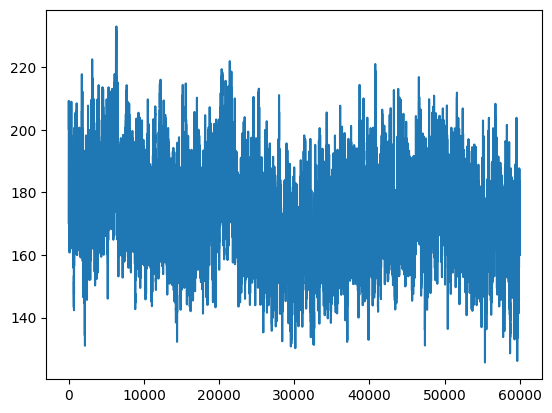

In [67]:
plt.figure()
plt.plot(np.linspace(0,SWEEPS,len(E0_list)),E0_list)
plt.show()

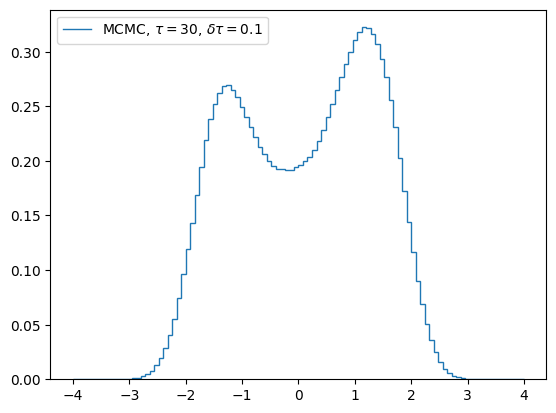

In [28]:
plt.figure()
plt.stairs(prob_histogram/np.sum(prob_histogram*DELTAX), x_bins, label=f"MCMC, $\\tau = {TAU}$, $\\delta\\tau={DELTATAU}$")
# plt.plot(x_bins, psi_analytical*psi_analytical.conjugate(), label="Analytical")
# plt.plot(x_bins,V(x_bins)/250)
plt.legend()
plt.savefig('ProbHistogramDeltatau0.1.jpg')
plt.show()



# plt.figure()
# plt.plot(np.linspace(0,TAU,len(x_path)),x_path)

In [ ]:
#estimating the energy

BURNIN = 100_000

m_mean = np.mean(m_values[BURNIN:])
m_std = np.std(m_values[BURNIN:])

plt.figure()
plt.plot(range(STEPS)[:BURNIN], m_values[:BURNIN], label="Burn in")
plt.plot(range(STEPS)[BURNIN:], m_values[BURNIN:], label="Sampling")
# show mean as dashed line
plt.plot(range(STEPS), m_mean * np.ones((STEPS)), "--", color="black")
# show variance as filled box
plt.fill_between(range(STEPS), m_mean - m_std, m_mean + m_std, color="gray", alpha=0.3)
plt.xlabel("Steps")
plt.ylabel("Magnetization")
plt.legend(title=f"T={T}")
plt.show()

print(f"magnetization mean = {m_mean}")
print(f"magnetization std = {m_std}")

Problem B: Plot the ground state probability distribution and compare it with the expected form.

In [34]:
np.shape(x_path)
print(prob_histogram)

[0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 1.40000e+01 5.10000e+01 9.50000e+01 1.68000e+02 3.89000e+02
 8.38000e+02 1.78500e+03 3.48100e+03 6.40200e+03 1.12580e+04 1.92120e+04
 3.09120e+04 4.72360e+04 6.87930e+04 9.65980e+04 1.33367e+05 1.78999e+05
 2.30317e+05 2.85617e+05 3.43147e+05 4.04691e+05 4.67485e+05 5.25702e+05
 5.71080e+05 6.05349e+05 6.29586e+05 6.44050e+05 6.47194e+05 6.35695e+05
 6.20040e+05 5.97912e+05 5.75912e+05 5.53834e+05 5.32140e+05 5.10825e+05
 4.94333e+05 4.80666e+05 4.69763e+05 4.63283e+05 4.62460e+05 4.60615e+05
 4.60939e+05 4.65523e+05 4.71770e+05 4.79871e+05 4.88680e+05 5.03328e+05
 5.23672e+05 5.47275e+05 5.75426e+05 6.04767e+05 6.35557e+05 6.65203e+05
 6.92355e+05 7.18854e+05 7.44997e+05 7.64074e+05 7.73718e+05 7.71606e+05
 7.58793e+05 7.37632e+05 7.04159e+05 6.64208e+05 6.14376e+05 5.54065e+05
 4.85697e+05 4.14490e+05 3.45069e+05 2.79101e+05 2.16544e+05 1.64670e+05
 1.22216e+05 8.68450e+04 5.97870e+04 3.84770e+04 2.

In [15]:

# Plot probability distribution
# plt.hist(x_path, bins=30, density=True, alpha=0.7, label="Probability Distribution")
# plt.xlabel("x")
# plt.ylabel("Probability Density")
# plt.legend()
# plt.show()


Problem C : Calculate the energy and probability distribution of the particle from the same simulation
code for a smaller value of τb. What is the expected probability distribution in this case? What does this
correspond to in terms of a statistical mechanics interpretation?